In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import os
print("Current directory:", os.getcwd())



Current directory: /content


In [4]:
# # Unzip to /content/dataset
# !unzip "/content/drive/MyDrive/XRAY/data.zip" -d /content/drive/MyDrive/Ctscan

In [5]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support


import warnings
warnings.filterwarnings ('ignore')

In [6]:
dataset_path = Path("/content/drive/MyDrive/Ctscan/brisc2025/classification_task")
dataset_path

Path('/content/drive/MyDrive/Ctscan/brisc2025/classification_task')

In [7]:
files = list(dataset_path.glob("*/*.jpg"))
print(f'Total Images = {len(files)}')

Total Images = 0


In [8]:
dataset_path.ls()


(#2) [Path('/content/drive/MyDrive/Ctscan/brisc2025/classification_task/train'),Path('/content/drive/MyDrive/Ctscan/brisc2025/classification_task/test')]

In [9]:
dls = ImageDataLoaders.from_folder(
    dataset_path, valid_pct=0.2,
    item_tfms=Resize(224),
    batch_tfms=[
        *aug_transforms(flip_vert=True, max_rotate=30.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2),
    ]
)

In [10]:
len(dls.train_ds)

4800

In [11]:
len(dls.valid_ds)

1200

In [12]:
dls

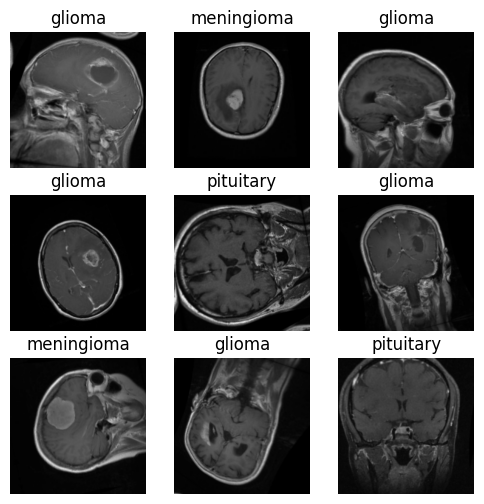

In [13]:
dls.show_batch(max_n=9, figsize=(6,6))
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

def multiclass_precision(preds, targs):
    # Eğer tensör ise, CPU'ya al ve numpy dizisine çevir
    if hasattr(preds, 'detach'):
        preds = preds.detach().cpu().numpy()
    if hasattr(targs, 'detach'):
        targs = targs.detach().cpu().numpy()
    # Eğer logits gibi çok boyutlu çıktı ise argmax al
    if preds.ndim > 1:
        preds = preds.argmax(axis=1)
    return precision_score(targs, preds, average='macro')

def multiclass_recall(preds, targs):
    if hasattr(preds, 'detach'):
        preds = preds.detach().cpu().numpy()
    if hasattr(targs, 'detach'):
        targs = targs.detach().cpu().numpy()
    if preds.ndim > 1:
        preds = preds.argmax(axis=1)
    return recall_score(targs, preds, average='macro')

def multiclass_f1(preds, targs):
    if hasattr(preds, 'detach'):
        preds = preds.detach().cpu().numpy()
    if hasattr(targs, 'detach'):
        targs = targs.detach().cpu().numpy()
    if preds.ndim > 1:
        preds = preds.argmax(axis=1)
    return f1_score(targs, preds, average='macro')

In [15]:
from fastai.losses import CrossEntropyLossFlat
from fastai.vision.all import vision_learner, resnet34

learn = vision_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(), metrics=[accuracy, multiclass_precision, multiclass_recall, multiclass_f1], model_dir=Path("/kaggle/working/models"))

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 194MB/s]


In [16]:
from google.colab import drive
from pathlib import Path

# Mount Google Drive
drive.mount('/content/drive')

# Set export path in your Drive
learn.path = Path("/content/drive/MyDrive")
learn.export("model.pkl")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


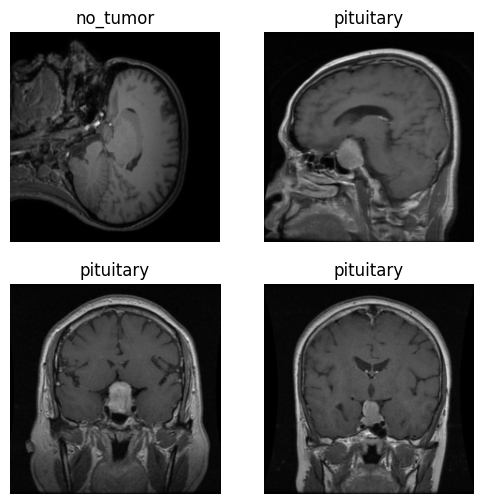

In [17]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
).dataloaders(dataset_path)

dls.show_batch(max_n=4)


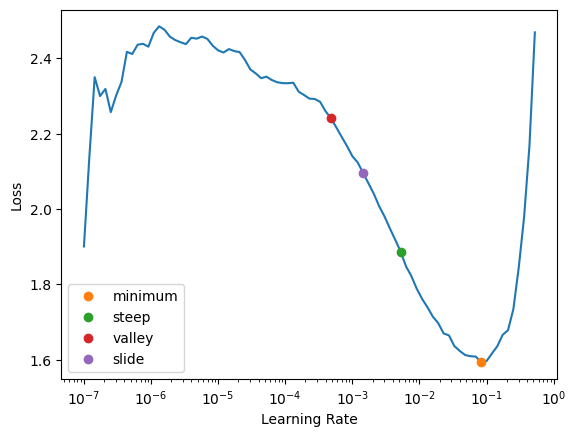

In [20]:
from fastai.callback import *

suggest_funcs = (minimum, steep, valley, slide)
lrs = learn.lr_find(suggest_funcs=suggest_funcs)
figsize=(10,10)

plt.show()

In [21]:
lrs

SuggestedLRs(minimum=0.00831763744354248, steep=0.005248074419796467, valley=0.0004786300996784121, slide=0.0014454397605732083)

In [22]:
print(f"Önerilen minimum öğrenme oranı: {lrs.minimum}, en dik eğim noktası: {lrs.steep}")

Önerilen minimum öğrenme oranı: 0.00831763744354248, en dik eğim noktası: 0.005248074419796467


In [23]:
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback

# Callback'leri tanımla
early_stopping = EarlyStoppingCallback(monitor='valid_loss', patience=10)
model_checkpoint = SaveModelCallback(monitor='valid_loss', fname='best_model')

# Eğitim
learn.fit_one_cycle(50, lr_max=lrs.minimum, cbs=[early_stopping, model_checkpoint])

epoch,train_loss,valid_loss,accuracy,multiclass_precision,multiclass_recall,multiclass_f1,time
0,0.904954,0.520816,0.822500,0.826248,0.816677,0.806476,03:49
1,0.620710,0.329532,0.890000,0.893682,0.882449,0.883608,00:43
2,0.439032,0.288035,0.905000,0.913993,0.899353,0.898659,00:45
3,0.348307,0.201952,0.932500,0.938717,0.929996,0.930225,00:44
4,0.281783,0.281864,0.905833,0.921015,0.898918,0.904273,00:44
5,0.253968,0.203199,0.932500,0.938285,0.923444,0.927060,00:44
6,0.214914,0.112171,0.960833,0.964795,0.956726,0.958739,00:44
7,0.217691,0.144023,0.950000,0.953618,0.949808,0.949351,00:44
8,0.219146,0.357080,0.915833,0.929851,0.913678,0.910306,00:44
9,0.217991,0.252267,0.921667,0.929177,0.920612,0.918758,00:44


Better model found at epoch 0 with valid_loss value: 0.5208156704902649.
Better model found at epoch 1 with valid_loss value: 0.3295316696166992.
Better model found at epoch 2 with valid_loss value: 0.28803521394729614.
Better model found at epoch 3 with valid_loss value: 0.20195230841636658.
Better model found at epoch 6 with valid_loss value: 0.11217093467712402.
Better model found at epoch 13 with valid_loss value: 0.10469666868448257.
Better model found at epoch 20 with valid_loss value: 0.06370504945516586.
No improvement since epoch 20: early stopping


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

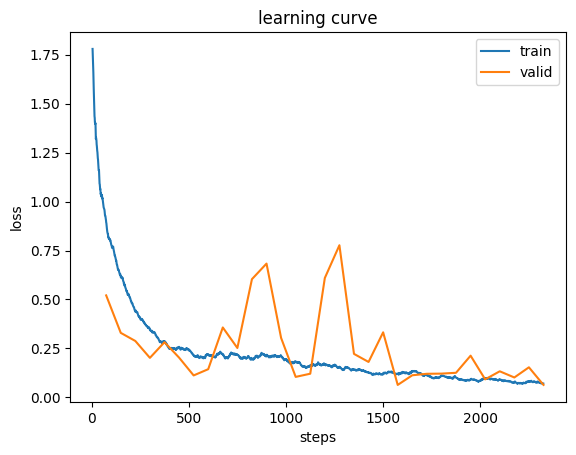

In [24]:
learn.recorder.plot_loss()

In [25]:
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [26]:
img = PILImage.create("/content/drive/MyDrive/Ctscan/brisc2025/classification_task/test/no_tumor/brisc2025_test_00575_no_ax_t1.jpg")  # Test için bir görsel yükle
learn.predict(img)

('no_tumor',
 tensor(2),
 tensor([3.1758e-06, 7.3557e-07, 1.0000e+00, 9.8137e-07]))

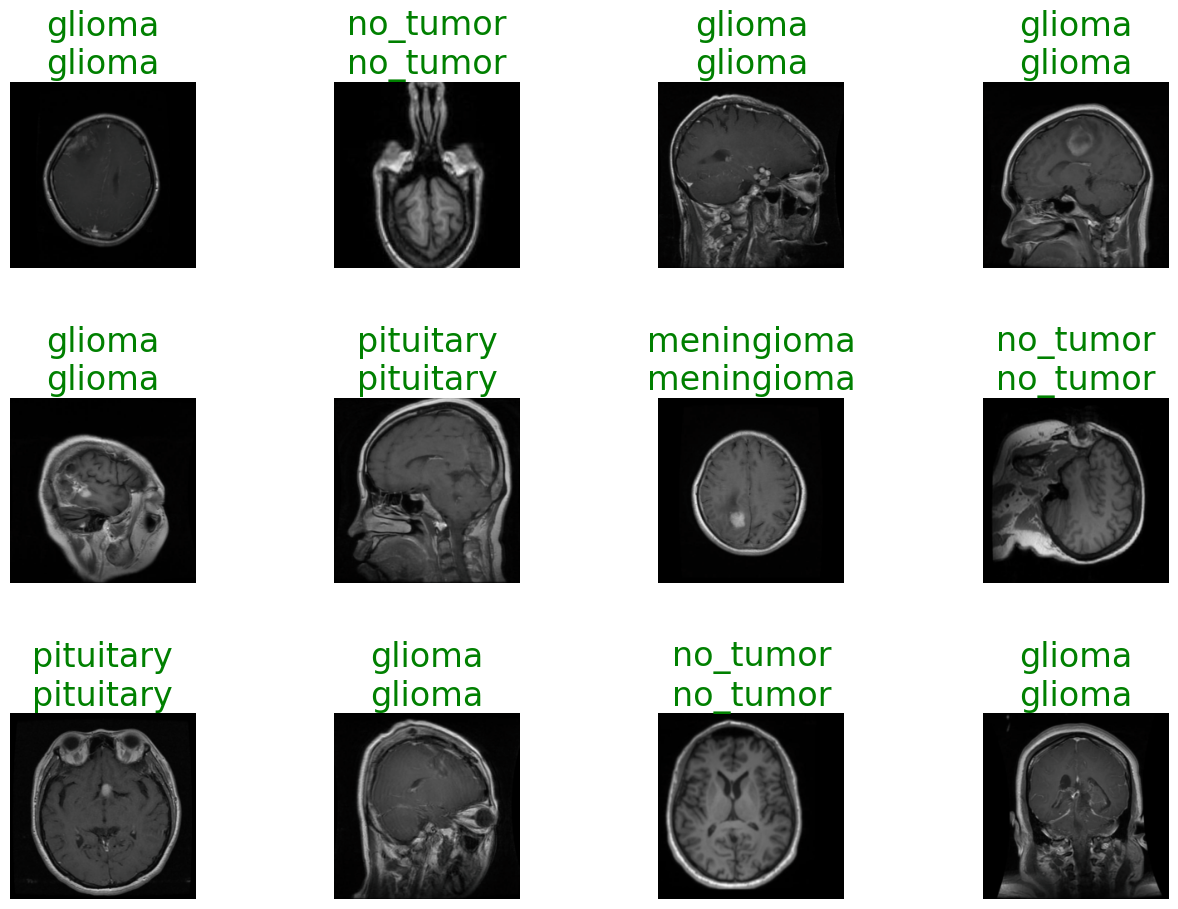

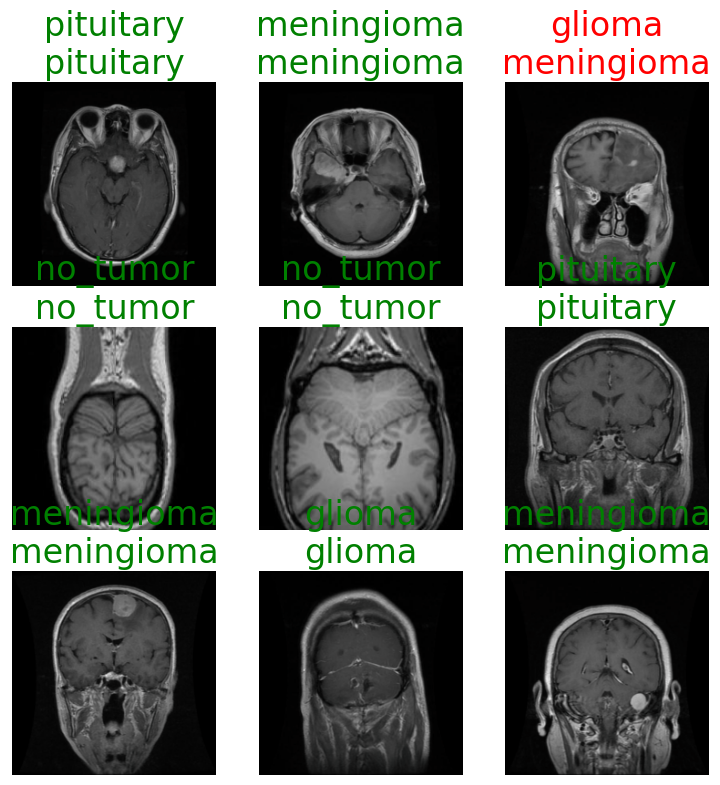

In [27]:
plt.rcParams.update({'font.size': 20})  # change default font size


# Show only 3 results
learn.show_results(max_n=12)

# Adjust spacing
plt.tight_layout(pad=0.2)       # add padding around subplots
plt.subplots_adjust(hspace=0.7, wspace=0.5)  # hspace=vertical, wspace=horizontal
plt.show()

learn.show_results()

In [28]:
from fastai.vision.all import *

# Get predictions and targets
preds, targets = learn.get_preds()
pred_labels = preds.argmax(dim=1)

# Decode to class names
actual = [learn.dls.vocab[t] for t in targets]
predicted = [learn.dls.vocab[p] for p in pred_labels]

# Show side-by-side
import pandas as pd
df = pd.DataFrame({'Actual': actual, 'Predicted': predicted})
print(df.head(25))


        Actual   Predicted
0     no_tumor    no_tumor
1       glioma      glioma
2       glioma  meningioma
3   meningioma  meningioma
4     no_tumor    no_tumor
5       glioma      glioma
6     no_tumor    no_tumor
7       glioma      glioma
8    pituitary   pituitary
9       glioma      glioma
10    no_tumor    no_tumor
11    no_tumor    no_tumor
12    no_tumor    no_tumor
13   pituitary   pituitary
14    no_tumor    no_tumor
15   pituitary   pituitary
16    no_tumor    no_tumor
17  meningioma  meningioma
18      glioma      glioma
19   pituitary   pituitary
20      glioma      glioma
21    no_tumor    no_tumor
22  meningioma  meningioma
23   pituitary   pituitary
24    no_tumor    no_tumor


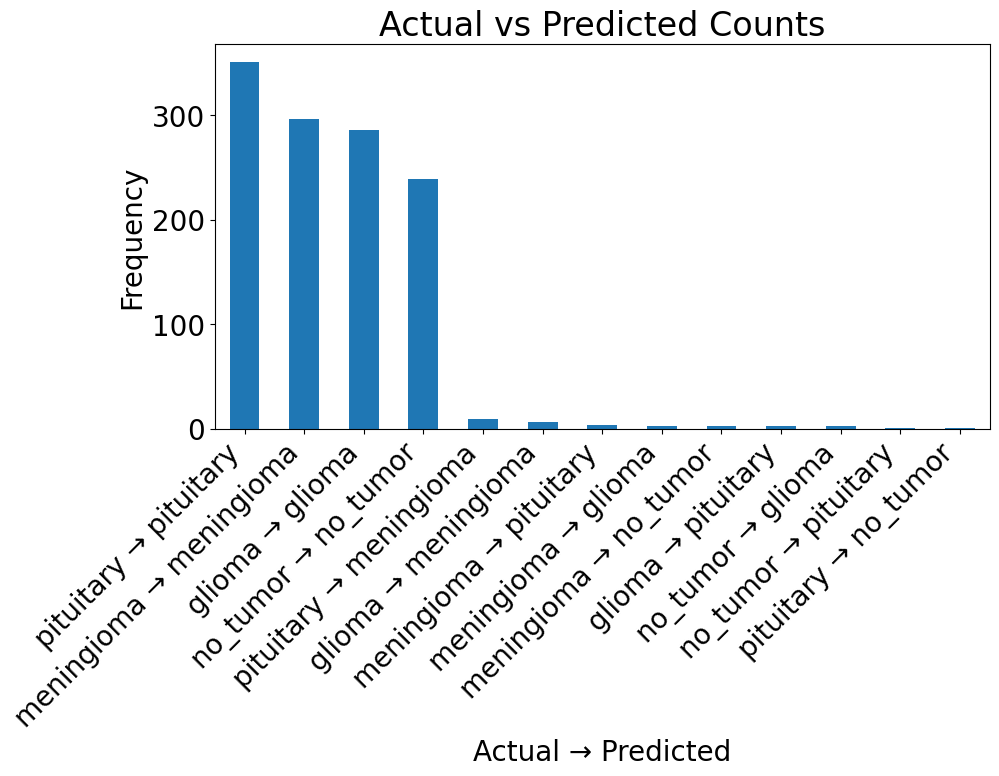

In [29]:
import matplotlib.pyplot as plt

df['Comparison'] = df['Actual'] + " → " + df['Predicted']
df['Comparison'].value_counts().plot(kind='bar', figsize=(10,5))

plt.title("Actual vs Predicted Counts")
plt.xlabel("Actual → Predicted")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.show()


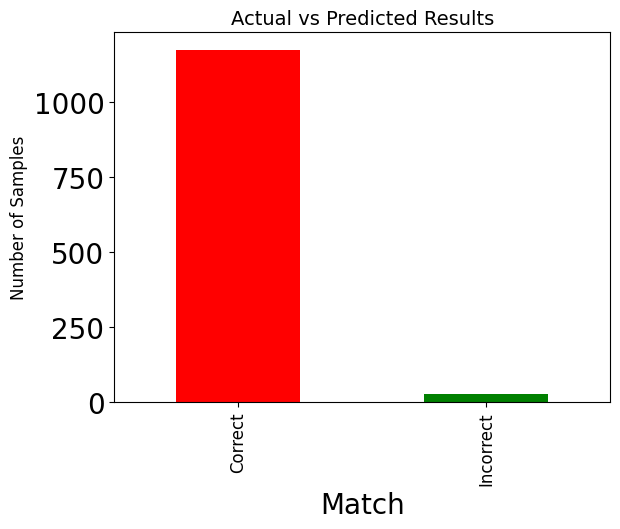

In [30]:
import matplotlib.pyplot as plt

# Count mismatches and matches
df['Match'] = df['Actual'] == df['Predicted']
df['Match'].value_counts().plot(kind='bar', color=['red','green'])

plt.xticks([0,1], ['Correct', 'Incorrect'], fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Actual vs Predicted Results", fontsize=14)
plt.show()


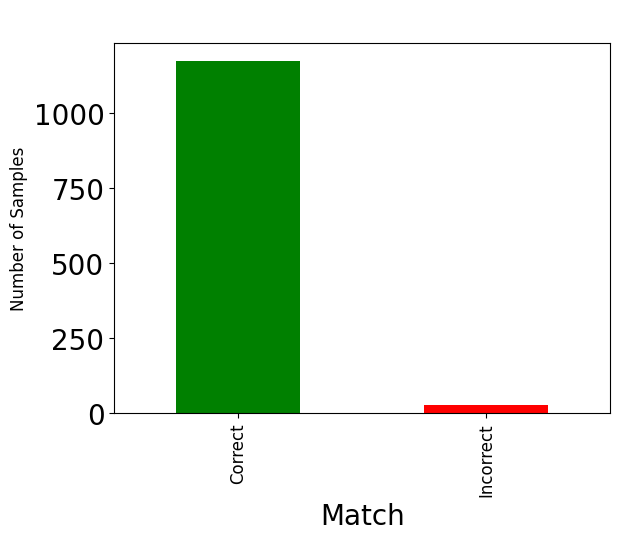

In [31]:
import matplotlib.pyplot as plt

# Count mismatches and matches
df['Match'] = df['Actual'] == df['Predicted']
counts = df['Match'].value_counts()

# Ensure consistent order: [Correct (True), Incorrect (False)]
counts = counts.reindex([True, False])

# Plot with fixed colors
counts.plot(kind='bar', color=['green', 'red'])

plt.xticks([0,1], ['Correct', 'Incorrect'], fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.title("Actual vs Predicted Results", fontsize=14)
plt.title(" ")
plt.show()

plt.rcParams.update({'font.size': 25})  # change default font size


In [32]:
from sklearn.metrics import classification_report
preds, targets = learn.get_preds()
class_report = classification_report(targets, torch.argmax(preds, dim=1), target_names=dls.vocab)
print(class_report)

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       294
  meningioma       0.95      0.98      0.96       303
    no_tumor       0.99      0.99      0.99       242
   pituitary       0.98      0.97      0.98       361

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



Accuracy: 0.98


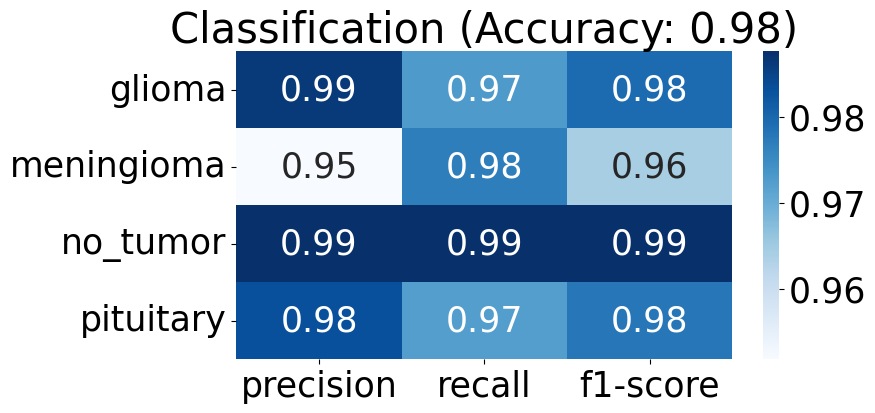

In [53]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
plt.rcParams.update({'font.size': 25})
figsize=(6,6)
# Get predictions and targets
preds, targets = learn.get_preds()
y_pred = torch.argmax(preds, dim=1)

# Get classification report as a dictionary
class_report = classification_report(
    targets,
    y_pred,
    target_names=dls.vocab,
    output_dict=True
)

# Extract overall accuracy
accuracy = class_report["accuracy"]
print(f"Accuracy: {accuracy:.2f}")

# Convert to DataFrame
df = pd.DataFrame(class_report).transpose()

# Keep only class-wise metrics (precision, recall, f1-score)
df_class_only = df.iloc[:-3, :3]

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_class_only, annot=True, fmt=".2f", cmap="Blues")
plt.title(f"Classification (Accuracy: {accuracy:.2f})")
plt.yticks(rotation=0)
plt.show()


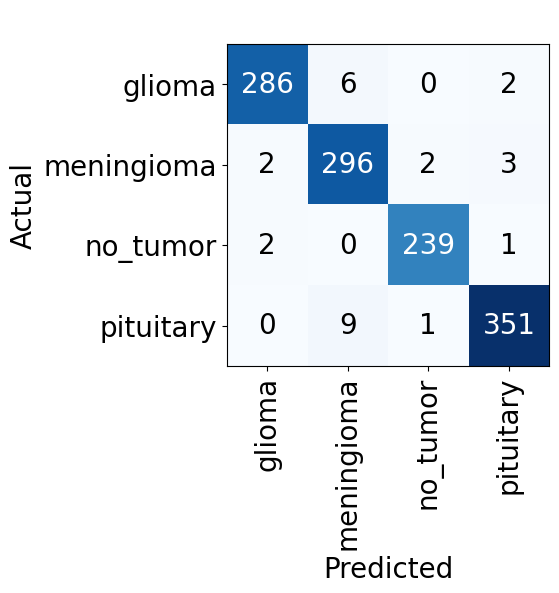

In [36]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})  # change default font size

interp.plot_confusion_matrix(figsize=(6,6))
plt.title(" ")
plt.show()


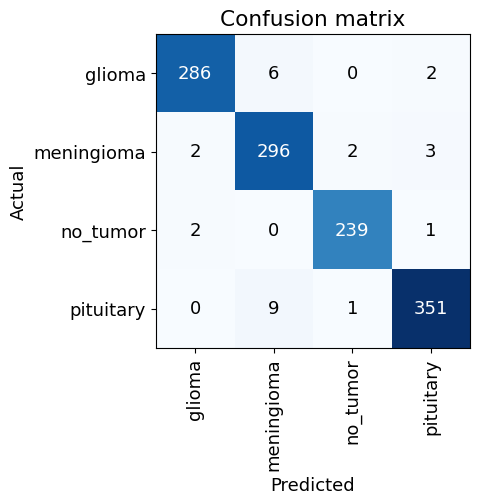

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))

plt.show()


In [37]:
dataset_path


Path('/content/drive/MyDrive/Ctscan/brisc2025/classification_task')

In [38]:
preds, y_true, _ = learn.get_preds(dl=dls.valid, with_decoded=True)

# Eğer preds çok boyutlu ise argmax alarak tahmin etiketlerini elde ediyoruz
preds_labels = preds.argmax(dim=1)


Accuracy: 0.98


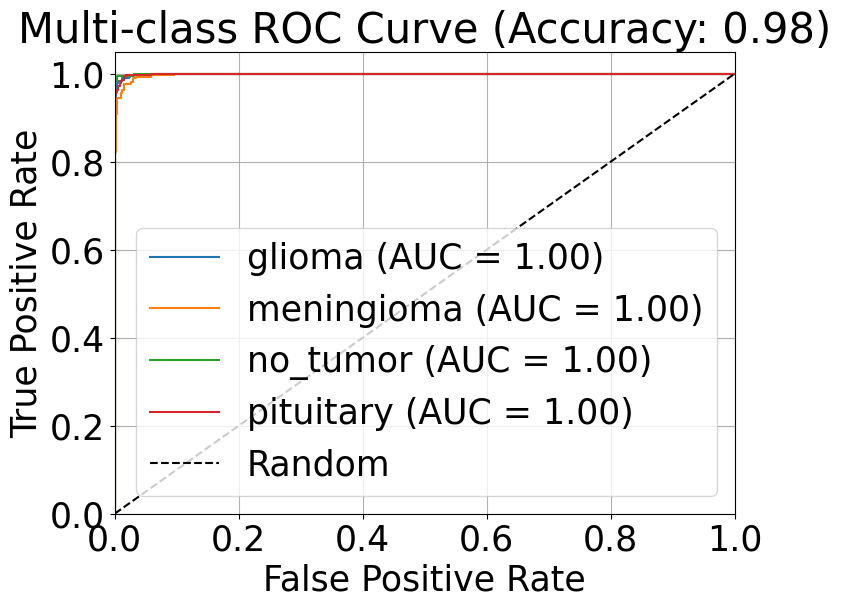

In [57]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import torch
import numpy as np
plt.rcParams.update({'font.size': 25})
# Get predictions and targets
preds, targets = learn.get_preds()
y_true = targets.cpu().numpy()
y_score = preds.cpu().numpy()  # Probabilities for each class
y_pred = torch.argmax(preds, dim=1).cpu().numpy()

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.2f}")

# One-vs-Rest ROC for each class
n_classes = y_score.shape[1]
fpr = {}
tpr = {}
roc_auc = {}

# Binarize the true labels for ROC
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(dls.vocab):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Multi-class ROC Curve (Accuracy: {acc:.2f})')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Accuracy: 0.98


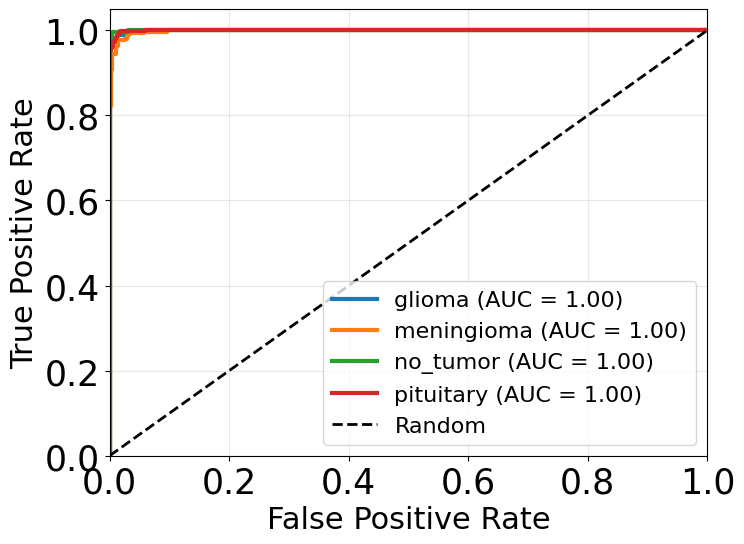

In [64]:
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import torch
import numpy as np

# Increase global font size
plt.rcParams.update({'font.size': 25})

# Get predictions and targets
preds, targets = learn.get_preds()
y_true = targets.cpu().numpy()
y_score = preds.cpu().numpy()  # Probabilities for each class
y_pred = torch.argmax(preds, dim=1).cpu().numpy()

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.2f}")

# One-vs-Rest ROC for each class
n_classes = y_score.shape[1]
fpr, tpr, roc_auc = {}, {}, {}

# Binarize the true labels for ROC
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(dls.vocab):
    plt.plot(fpr[i], tpr[i],
             linewidth=3,
             label=f'{class_name} (AUC = {roc_auc[i]:.2f})')

# Random guess line
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')

# Graph formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=22)
plt.ylabel('True Positive Rate', fontsize=22)
# plt.title(f'Multi-class ROC Curve: {acc:.2f})', fontsize=24)
plt.legend(loc='lower right', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [40]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_true, preds_labels, average='weighted')

# Accuracy'yi ayrı hesaplamak için get_preds'i tekrar kullanabiliriz:
acc = accuracy(*learn.get_preds(dl=dls.valid))

print(f"Validation Seti Performansı:")
print(f"Accuracy: {acc.item():.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Validation Seti Performansı:
Accuracy: 0.3608
Precision: 0.4045
Recall: 0.3608
F1 Score: 0.2365


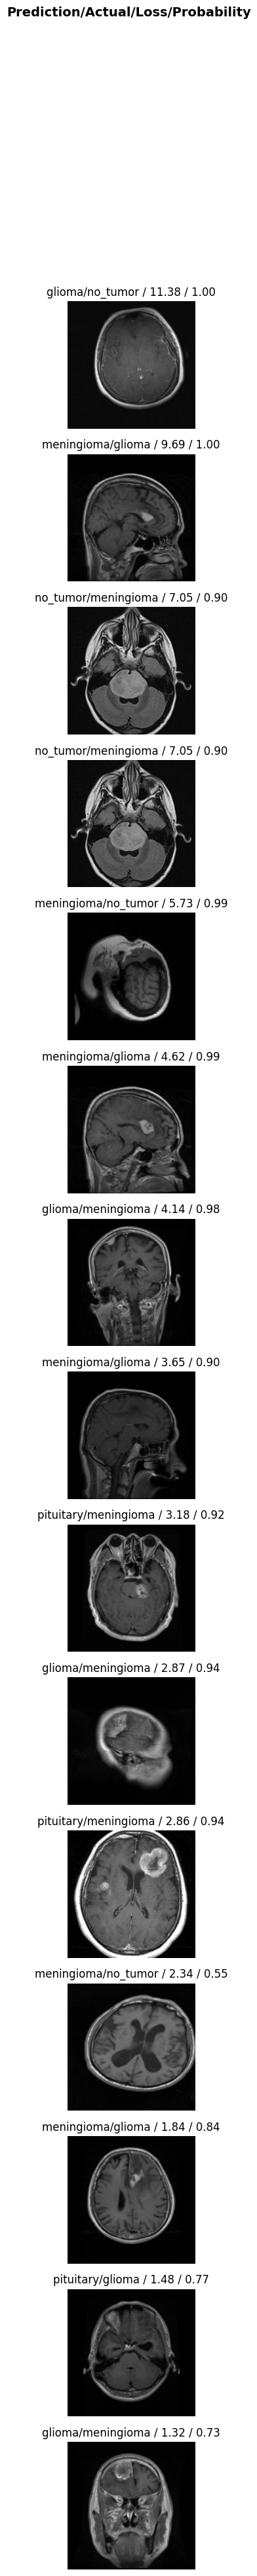

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(15, nrows=15)

In [ ]:
img = PILImage.create("/content/drive/MyDrive/Ctscan/brisc2025/classification_task/test/no_tumor/brisc2025_test_00579_no_ax_t1.jpg")  # Test için bir görsel yükle
pred, pred_idx, probs = learn.predict(img)
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

Prediction: no_tumor, Probability: 1.0000


Prediction: no_tumor, Probability: 1.0000


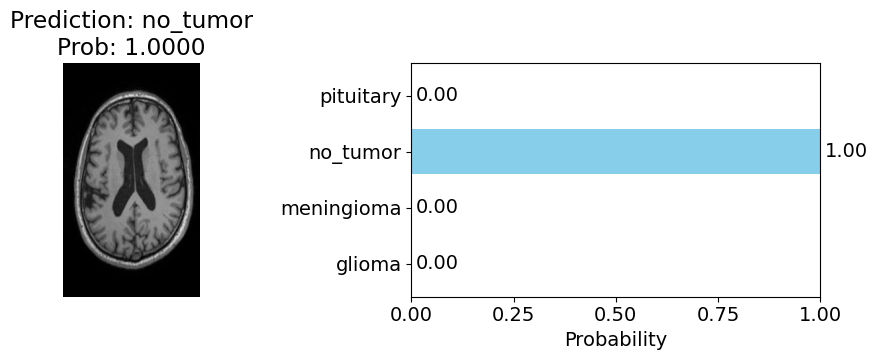

In [ ]:
from fastai.vision.all import *
import matplotlib.pyplot as plt
import numpy as np

# Load image
img_path = "/content/drive/MyDrive/Ctscan/brisc2025/classification_task/test/no_tumor/brisc2025_test_00579_no_ax_t1.jpg"
img = PILImage.create(img_path)

# Predict
pred, pred_idx, probs = learn.predict(img)

# Print text result
print(f"Prediction: {pred}, Probability: {probs[pred_idx]:.4f}")

# --- Plot ---
plt.figure(figsize=(10,4))

# Show the image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred}\nProb: {probs[pred_idx]:.4f}")

# Show probability bar chart
plt.subplot(1, 2, 2)
class_names = learn.dls.vocab
y_pos = np.arange(len(class_names))
plt.barh(y_pos, probs, align='center', color='skyblue')
plt.yticks(y_pos, class_names)
plt.xlabel('Probability')
plt.xlim(0, 1)
plt.title('Prediction Probabilities')

# Add values on bars
for i, v in enumerate(probs):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')
plt.rcParams.update({'font.size': 20})
plt.tight_layout()
plt.title(" ")
plt.show()
